# Which Car is Best ? Analysing and Predicting MOT Test Results

In this experiment, we will be analysing the MOT test results of cars in the UK. The MOT test is an annual test of vehicle safety, roadworthiness aspects and exhaust emissions required in the United Kingdom for most vehicles over three years old. The MOT test is designed to ensure that a vehicle is roadworthy and safe to drive. The test checks the vehicle against a number of criteria, including the condition of the vehicle's brakes, lights, tyres, exhaust emissions, and more.

The dataset we will be using in this experiment is the [UK MOT test results dataset](https://www.data.gov.uk/dataset/e3939ef8-30c7-4ca8-9c7c-ad9475cc9b2f/anonymised-mot-tests-and-results) for 2023. Information includes the make, model, and year of the car, as well as the overal test result.

Let us start by loading the dataset and taking a look at the first few rows.

In [1]:
# Load .data/mot/test_results.csv as a dataframe

import pandas as pd

mot = pd.read_csv('.data/mot/test_result.csv', sep='|')

# drop the test_id and vehicle_id columns
mot = mot.drop(['test_id'], axis=1)
mot

,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
0,838565361,2023-01-02,4,NT,P,179357.0,NW,TOYOTA,PRIUS +,WHITE,HY,1798.0,2016-06-17
1,484499974,2023-01-01,4,NT,P,300072.0,B,TOYOTA,PRIUS,RED,HY,1500.0,2008-09-13
2,53988366,2023-01-02,4,NT,PRS,307888.0,HA,TOYOTA,PRIUS,GREY,HY,1497.0,2010-01-15
3,606755010,2023-01-02,4,NT,F,65810.0,SE,TOYOTA,PRIUS,SILVER,HY,1497.0,2007-03-28
4,606755010,2023-01-02,4,RT,P,65810.0,SE,TOYOTA,PRIUS,SILVER,HY,1497.0,2007-03-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
42216716,1401380910,2023-12-31,4,NT,P,85583.0,EN,HONDA,BEAT,SILVER,PE,660.0,1999-10-01
42216717,625178603,2023-12-31,7,NT,P,227563.0,SK,RENAULT,MASTER,WHITE,DI,2298.0,2016-09-01
42216718,820545620,2023-12-31,4,NT,P,120115.0,S,PEUGEOT,207,SILVER,DI,1560.0,2010-01-21
42216719,941704896,2023-12-31,4,NT,P,141891.0,S,NISSAN,MICRA,RED,PE,1240.0,2009-06-25


Let us also load a few lookup tables that will help us in our analysis, and merge them with the main dataset.

In [2]:
# Load .data/mot/lookup/mdr_fuel_types.csv as a dataframe
fuel_types = pd.read_csv('.data/mot/lookup/mdr_fuel_types.csv', sep='|')

# Merge the two dataframes on the fuel_type column
mot = pd.merge(mot, fuel_types, left_on='fuel_type', right_on='type_code', how='left', suffixes=('', '_desc'))

# Load .data/mot/lookup/mdr_test_outcome.csv as a dataframe
test_outcome = pd.read_csv('.data/mot/lookup/mdr_test_outcome.csv', sep='|')
mot = pd.merge(mot, test_outcome, left_on='test_result', right_on='result_code', how='left', suffixes=('', '_desc'))
mot.drop(['type_code', 'result_code'], axis=1, inplace=True)
mot.rename(columns={'result': 'test_result_desc'}, inplace=True)
mot

,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date,fuel_type_desc,test_result_desc
0,838565361,2023-01-02,4,NT,P,179357.0,NW,TOYOTA,PRIUS +,WHITE,HY,1798.0,2016-06-17,Hybrid Electric (Clean),Passed
1,484499974,2023-01-01,4,NT,P,300072.0,B,TOYOTA,PRIUS,RED,HY,1500.0,2008-09-13,Hybrid Electric (Clean),Passed
2,53988366,2023-01-02,4,NT,PRS,307888.0,HA,TOYOTA,PRIUS,GREY,HY,1497.0,2010-01-15,Hybrid Electric (Clean),Pass with Rectification at Station
3,606755010,2023-01-02,4,NT,F,65810.0,SE,TOYOTA,PRIUS,SILVER,HY,1497.0,2007-03-28,Hybrid Electric (Clean),Failed
4,606755010,2023-01-02,4,RT,P,65810.0,SE,TOYOTA,PRIUS,SILVER,HY,1497.0,2007-03-28,Hybrid Electric (Clean),Passed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42216716,1401380910,2023-12-31,4,NT,P,85583.0,EN,HONDA,BEAT,SILVER,PE,660.0,1999-10-01,Petrol,Passed
42216717,625178603,2023-12-31,7,NT,P,227563.0,SK,RENAULT,MASTER,WHITE,DI,2298.0,2016-09-01,Diesel,Passed
42216718,820545620,2023-12-31,4,NT,P,120115.0,S,PEUGEOT,207,SILVER,DI,1560.0,2010-01-21,Diesel,Passed
42216719,941704896,2023-12-31,4,NT,P,141891.0,S,NISSAN,MICRA,RED,PE,1240.0,2009-06-25,Petrol,Passed


This is a reasonably large dataset with over 41 million rows and 13 columns. For this experiment, we will be focusing on a subset of cars - the top 20 most tested cars in the dataset. We will be analysing the test results of these cars and building a machine learning model to predict the test result of a car based on its features, including make, model and mileage.

## Pre-processing

First let us perform some simple pre-processing steps on the dataset, to remove any data that is not relevant to our analysis and to perform some basic tidying. We will also calculate a few additional columns that will be useful for our analysis.

In [3]:
# Drop any first_use and test_date before 1970, to avoid invalid ages due to the UNIX epoch
mot = mot[mot['first_use_date'] >= '1970-01-01']
mot = mot[mot['test_date'] >= '1970-01-01']

# Calculate an age column (in days) based on the test_date and first_use_date columns
mot['test_date'] = pd.to_datetime(mot['test_date'])
mot['first_use_date'] = pd.to_datetime(mot['first_use_date'])
mot['age'] = (mot['test_date'] - mot['first_use_date']).dt.days
mot['age_years'] = mot['age'] / 365.25

# Combine make and model into one column
mot['make_model'] = mot['make'] + ' ' + mot['model']  # Combine make and model into one column

# Let us focus on data where cylinder capacity is between 500 and 5000
mot = mot[(mot['cylinder_capacity'] >= 500) & (mot['cylinder_capacity'] <= 5000)]

# Drop any negative ages, as they are likely to be errors
mot = mot[mot['age'] >= 0]
mot

,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date,fuel_type_desc,test_result_desc,age,age_years,make_model
0,838565361,2023-01-02,4,NT,P,179357.0,NW,TOYOTA,PRIUS +,WHITE,HY,1798.0,2016-06-17,Hybrid Electric (Clean),Passed,2390,6.543463,TOYOTA PRIUS +
1,484499974,2023-01-01,4,NT,P,300072.0,B,TOYOTA,PRIUS,RED,HY,1500.0,2008-09-13,Hybrid Electric (Clean),Passed,5223,14.299795,TOYOTA PRIUS
2,53988366,2023-01-02,4,NT,PRS,307888.0,HA,TOYOTA,PRIUS,GREY,HY,1497.0,2010-01-15,Hybrid Electric (Clean),Pass with Rectification at Station,4735,12.963723,TOYOTA PRIUS
3,606755010,2023-01-02,4,NT,F,65810.0,SE,TOYOTA,PRIUS,SILVER,HY,1497.0,2007-03-28,Hybrid Electric (Clean),Failed,5759,15.767283,TOYOTA PRIUS
4,606755010,2023-01-02,4,RT,P,65810.0,SE,TOYOTA,PRIUS,SILVER,HY,1497.0,2007-03-28,Hybrid Electric (Clean),Passed,5759,15.767283,TOYOTA PRIUS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42216716,1401380910,2023-12-31,4,NT,P,85583.0,EN,HONDA,BEAT,SILVER,PE,660.0,1999-10-01,Petrol,Passed,8857,24.249144,HONDA BEAT
42216717,625178603,2023-12-31,7,NT,P,227563.0,SK,RENAULT,MASTER,WHITE,DI,2298.0,2016-09-01,Diesel,Passed,2677,7.329227,RENAULT MASTER
42216718,820545620,2023-12-31,4,NT,P,120115.0,S,PEUGEOT,207,SILVER,DI,1560.0,2010-01-21,Diesel,Passed,5092,13.941136,PEUGEOT 207
42216719,941704896,2023-12-31,4,NT,P,141891.0,S,NISSAN,MICRA,RED,PE,1240.0,2009-06-25,Petrol,Passed,5302,14.516085,NISSAN MICRA


That's looking better, and we now have a couple of more columns - a combined make and model column, and a column for the age of the car based on the first use date and the actual test date. Now let us sample the top 20 most tested cars from the dataset.

In [4]:
# Sample the data for only the top 20 make and model combinations
top_20 = mot['make_model'].value_counts().head(20).index
mot = mot[mot['make_model'].isin(top_20)]
mot

,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date,fuel_type_desc,test_result_desc,age,age_years,make_model
21,1493398641,2023-01-01,4,NT,P,41682.0,SR,NISSAN,JUKE,GREY,DI,1461.0,2016-05-13,Diesel,Passed,2424,6.636550,NISSAN JUKE
25,1200062230,2023-01-01,4,NT,P,91473.0,G,VOLKSWAGEN,GOLF,SILVER,DI,1598.0,2010-03-20,Diesel,Passed,4670,12.785763,VOLKSWAGEN GOLF
26,1237843361,2023-01-01,4,NT,PRS,162891.0,B,VOLKSWAGEN,TRANSPORTER,WHITE,DI,1968.0,2012-10-01,Diesel,Pass with Rectification at Station,3744,10.250513,VOLKSWAGEN TRANSPORTER
30,922055125,2023-01-01,4,NT,P,21153.0,CO,FORD,FOCUS,BLACK,PE,999.0,2020-01-31,Petrol,Passed,1066,2.918549,FORD FOCUS
37,534002476,2023-01-01,4,NT,PRS,103365.0,B,HONDA,JAZZ,BLUE,PE,1339.0,2004-03-04,Petrol,Pass with Rectification at Station,6877,18.828200,HONDA JAZZ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42216701,700228101,2023-12-31,4,NT,PRS,105679.0,LU,NISSAN,JUKE,WHITE,PE,1598.0,2014-03-24,Petrol,Pass with Rectification at Station,3569,9.771389,NISSAN JUKE
42216705,677896545,2023-12-31,4,NT,P,169683.0,SA,AUDI,A3,RED,PE,1395.0,2014-12-16,Petrol,Passed,3302,9.040383,AUDI A3
42216709,541766398,2023-12-31,4,NT,P,79328.0,SP,VAUXHALL,ASTRA,BLACK,PE,1796.0,2008-03-06,Petrol,Passed,5778,15.819302,VAUXHALL ASTRA
42216710,144320145,2023-12-31,4,NT,P,53210.0,G,VAUXHALL,CORSA,RED,PE,1398.0,2019-05-31,Petrol,Passed,1675,4.585900,VAUXHALL CORSA


We are now down to just over 13 million rows, quite more manageable!

## Exploratory analysis

Let's try and gather some insights from the data. We will start by looking at the most common make/model combinations available in the data.

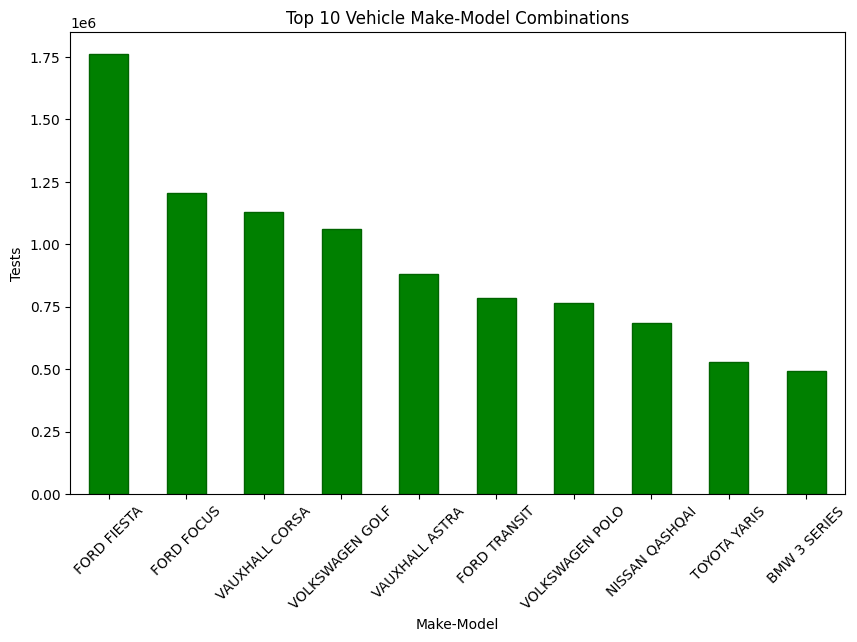

In [5]:
import matplotlib.pyplot as plt

# Calculate the top 10 most common make-model combinations
top_vehicles = mot['make_model'].value_counts().head(10)

# Plotting
plt.figure(figsize=(10, 6))
top_vehicles.plot(kind='bar', color='green', edgecolor='darkgreen')
plt.title('Top 10 Vehicle Make-Model Combinations')
plt.xlabel('Make-Model')
plt.ylabel('Tests')
plt.xticks(rotation=45)
plt.show()

That's interesting! The most common make/model combination is the Ford Fiesta, followed by the Ford Focus and the Vauxhall Corsa. These are all popular cars in the UK, so it makes sense that they are the most tested. Note that we are measuring *the number of tests* and not the number of cars, so it is possible that some cars have been tested multiple times.

Let's now perform a different visualisation which might be a bit more interesting, we will first show the distribution of car makes in relative terms as a treemap. In this case, let us remove any vehicle duplicates, so we only have one test per vehicle and therefore are comparing actual number of vehicles.

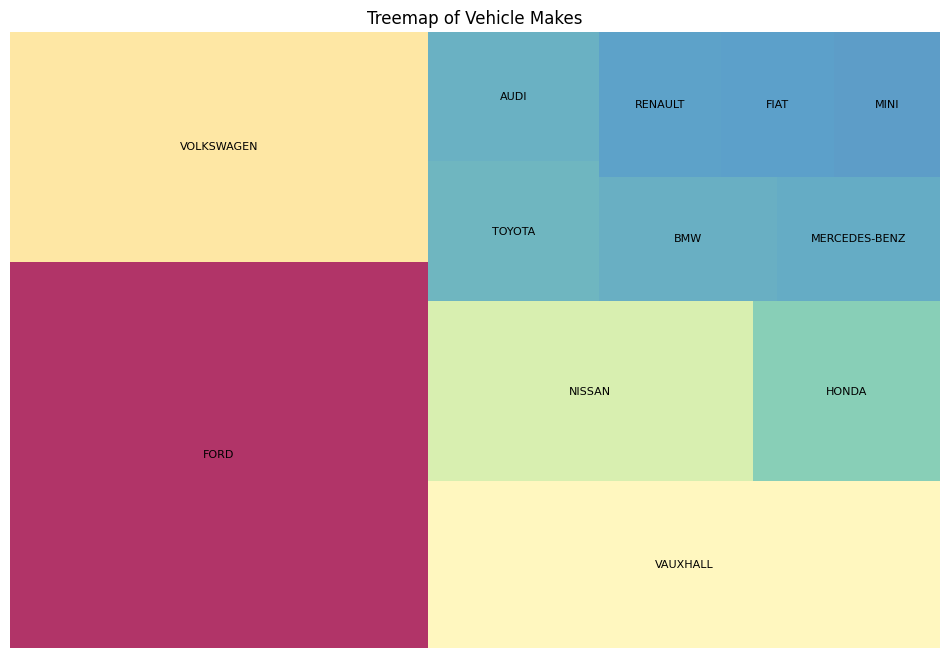

In [6]:
import squarify

# Calculate the top vehicle makes, while deduplicating for vehicle_id
counts = mot.drop_duplicates('vehicle_id')['make'].value_counts()

labels = counts.index
sizes = counts.values
colors = plt.cm.Spectral_r(sizes / max(sizes))  # Color coding by size

# Creating the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, text_kwargs={'fontsize': 8})
plt.title('Treemap of Vehicle Makes')
plt.axis('off')  # Remove axes
plt.show()

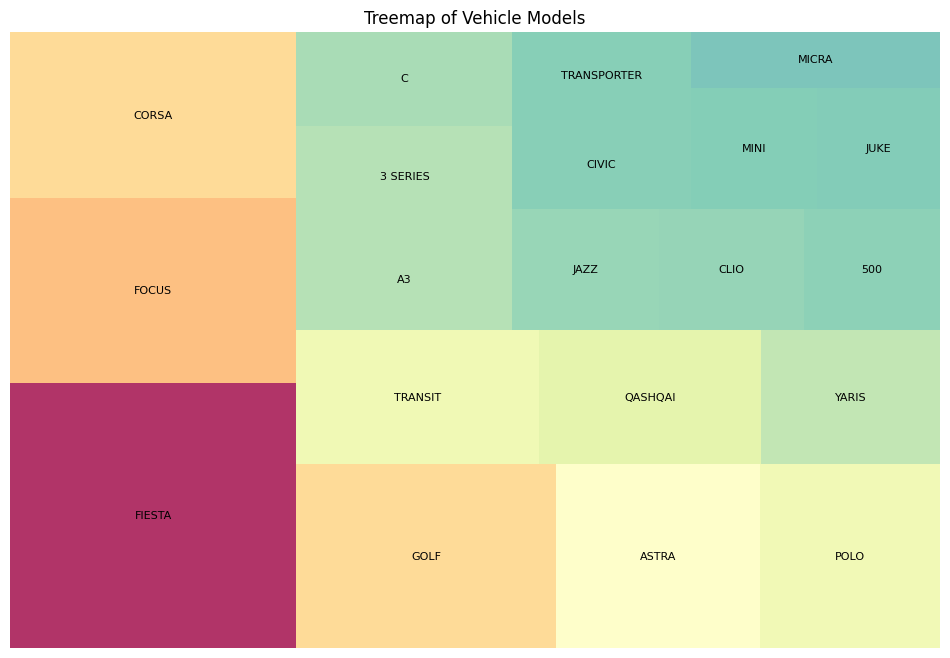

In [7]:
# Calculate the top vehicle models, while deduplicating for vehicle_id
counts = mot.drop_duplicates('vehicle_id')['model'].value_counts()

labels = counts.index
sizes = counts.values
colors = plt.cm.Spectral_r(sizes / max(sizes))  # Color coding by size

# Creating the treemap
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=0.8, text_kwargs={'fontsize': 8})
plt.title('Treemap of Vehicle Models')
plt.axis('off')  # Remove axes
plt.show()

This is quite informative! We can really see the relative popularity of different models, and the color coding gives a great visual representation of the distribution of both makes and models.

Now let us look at how vehicle age, make and model is distributed - this will help us get a better picture of the test results for each make and model. First let us understand the overal distribution of vehicle age in the dataset, as an histogram.

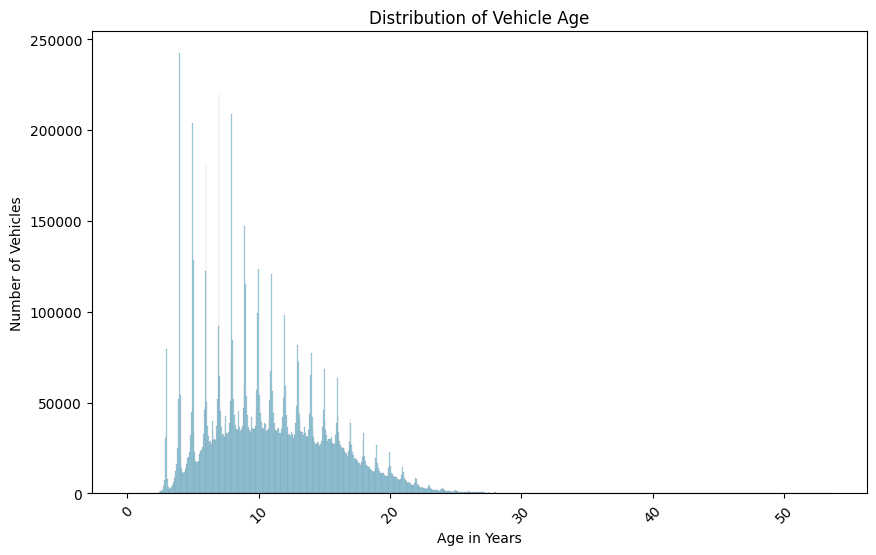

In [24]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(mot.drop_duplicates('vehicle_id')['age_years'], color='skyblue')
plt.title('Distribution of Vehicle Age')
plt.xlabel('Age in Years')
plt.xticks(rotation=45)
plt.ylabel('Number of Vehicles')
plt.show()


```{attention}
What do you think the spikes in the histogram represent?
```

Again, super informative. It would however be interesting to understand this as percentiles as well, so let us add that.

0.25     7.011636
0.50    10.206708
0.75    14.132786
0.95    19.537303
Name: age_years, dtype: float64


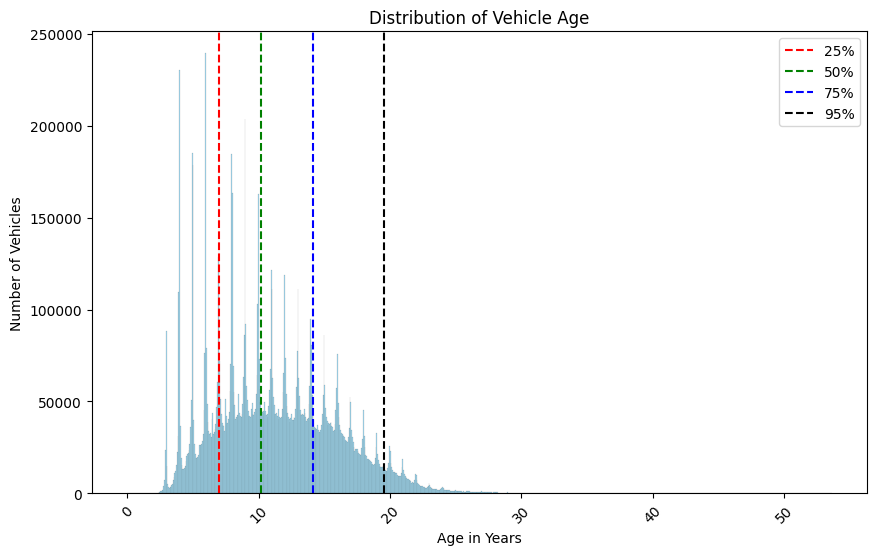

In [22]:
# Calculate and plot percentiles for the age_years column
percentiles = mot.drop_duplicates('vehicle_id')['age_years'].quantile([0.25, 0.5, 0.75, 0.95])
print(percentiles)

plt.figure(figsize=(10, 6))
sns.histplot(mot['age_years'], color='skyblue')
plt.axvline(percentiles.iloc[0], color='red', linestyle='--', label='25%')
plt.axvline(percentiles.iloc[1], color='green', linestyle='--', label='50%')
plt.axvline(percentiles.iloc[2], color='blue', linestyle='--', label='75%')
plt.axvline(percentiles.iloc[3], color='black', linestyle='--', label='95%')
plt.title('Distribution of Vehicle Age')
plt.xlabel('Age in Years')
plt.xticks(rotation=45)
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

Interesting! We conclude that only 25% of cars are newer than 7 years, and 50% are newer than 10 years. This information will be useful for our analysis, as we now know that half of the cars in the dataset are older than 10 years! Let us perform a similar analysis, but for mileage instead of age.

0.25     44084.0
0.50     70482.0
0.75    102157.0
0.95    157152.0
Name: test_mileage, dtype: float64


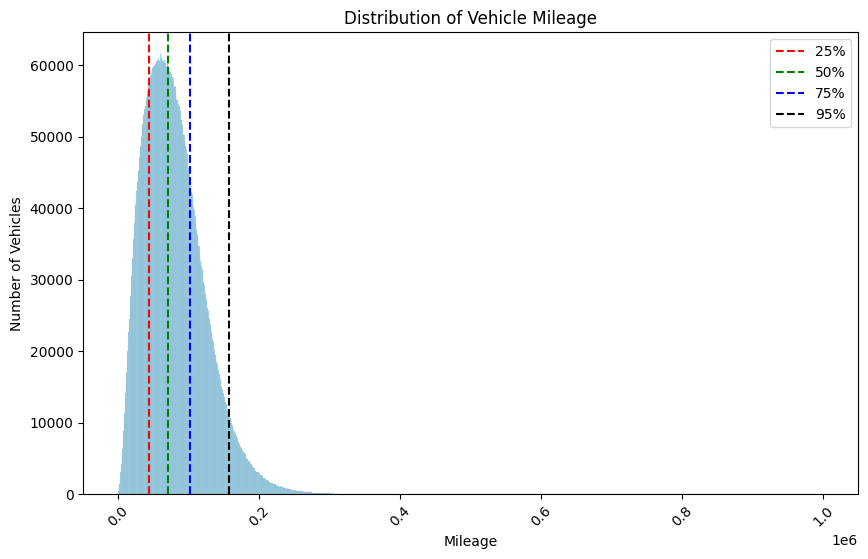

In [23]:
# Calculate and plot percentiles for the test_mileage column
percentiles = mot.drop_duplicates('vehicle_id')['test_mileage'].quantile([0.25, 0.5, 0.75, 0.95])
print(percentiles)

plt.figure(figsize=(10, 6))
sns.histplot(mot['test_mileage'], color='skyblue')
plt.axvline(percentiles.iloc[0], color='red', linestyle='--', label='25%')
plt.axvline(percentiles.iloc[1], color='green', linestyle='--', label='50%')
plt.axvline(percentiles.iloc[2], color='blue', linestyle='--', label='75%')
plt.axvline(percentiles.iloc[3], color='black', linestyle='--', label='95%')
plt.title('Distribution of Vehicle Mileage')
plt.xlabel('Mileage')
plt.xticks(rotation=45)
plt.ylabel('Number of Vehicles')
plt.legend()
plt.show()

Lots of information here. We can see that only 25% of cars have a mileage of less than aproximately 44000 miles, and half the cars have over 70000 miles on the clock! This is quite a lot of mileage, and it will be interesting to see how this affects the test results.

Let us now visually try to understand these distributions of age and mileage for each make and model. We are only ilustrating the visualisation technique, so let us look at age only - we could easily do the same for mileage. We will use a stacked histogram, where the `y` axis is the percentage of cars in each age group, and the `x` axis is the age of the car.

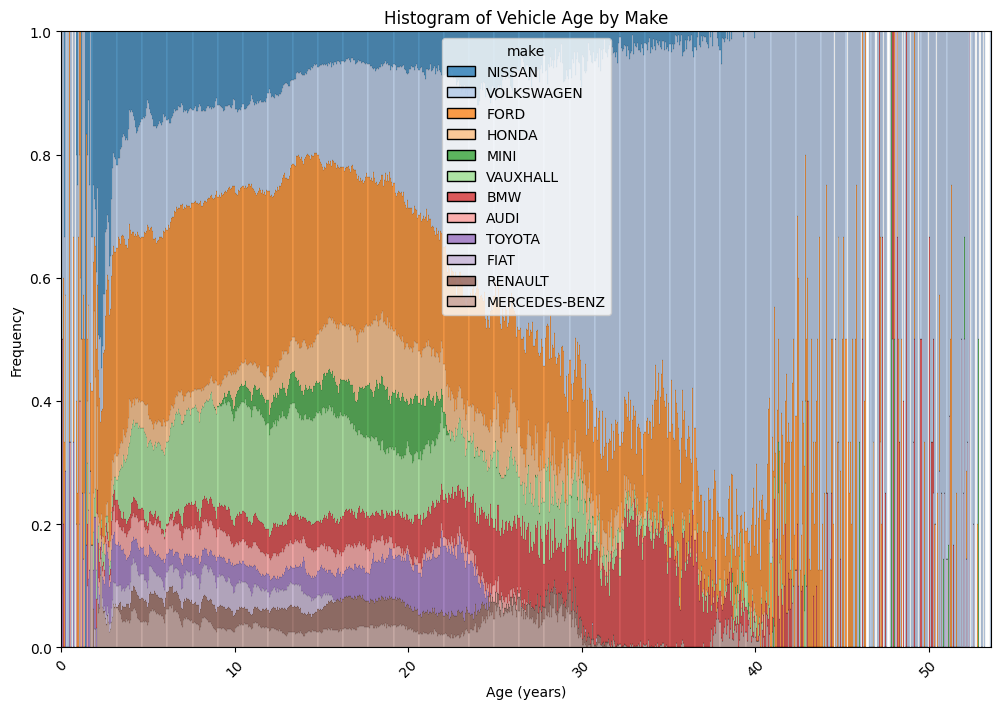

In [11]:
# Plot a matrix of histograms per make of the age of vehicles in years
plt.figure(figsize=(12, 8))
sns.histplot(data=mot, x='age_years', hue='make', multiple='fill', palette='tab20')
plt.title('Histogram of Vehicle Age by Make')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

There are *a lot* of old Volkswagens out on the road! This is quite interesting, and we can see that the distribution of ages for different makes is very different, ilustrating the popularity of different makes over time, a little bit like reading tree rings!

Let us perform the same analysis, but for models instead of makes.

/Users/NLeitao/.pyenv/versions/3.9.18/envs/ml-env/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


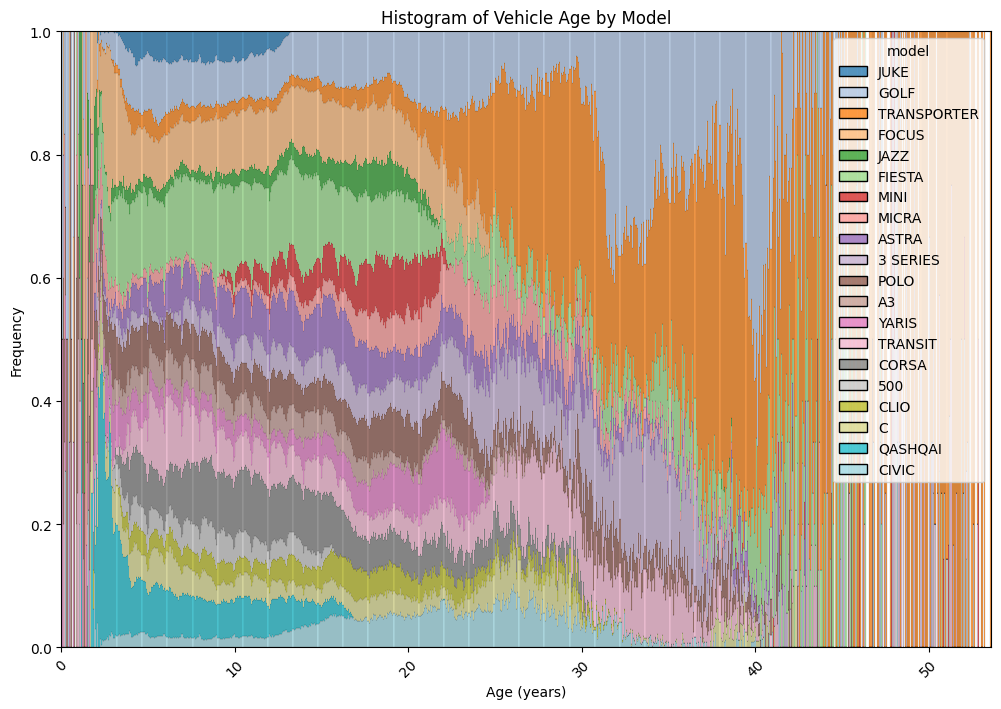

In [12]:
# Plot a matrix of histograms per model of the age of vehicles in years
plt.figure(figsize=(12, 8))
sns.histplot(data=mot, x='age_years', hue='model', multiple='fill', palette='tab20')
plt.title('Histogram of Vehicle Age by Model')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

The number of Golf's and Transporter vans helps to explain the make distribution we saw before. The effect we see is quite striking, and just like makes it ilustrates the popularity of different models over time.

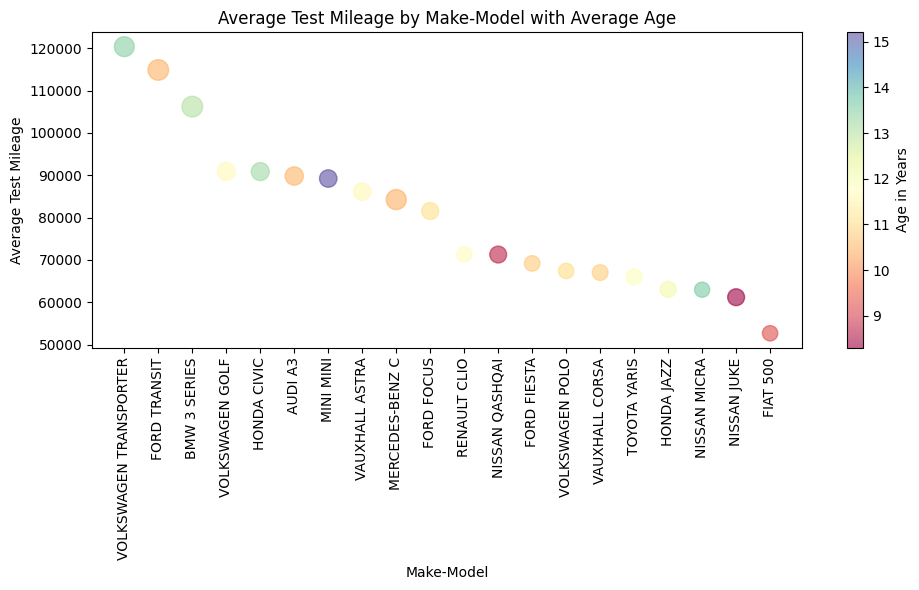

In [13]:
# Calculate the average test mileage
avg_mileage = mot.groupby(['make_model', 'make'])['test_mileage'].mean().reset_index()

# Calculate the average age in years for each make_model as a proxy for size
avg_age_years = mot.groupby(['make_model', 'make'])['age_years'].mean().reset_index()

# Calculate the average cylinder capacity for each make_model
avg_capacity = mot.groupby(['make_model', 'make'])['cylinder_capacity'].mean().reset_index()

# Merge the average mileage data with the average age years
merged_data = avg_mileage.merge(avg_age_years, on=['make_model', 'make'])

# Merge the merged data with the average capacity
merged_data = merged_data.merge(avg_capacity, on=['make_model', 'make'])

# Sort the data by average mileage
top_avg_mileage = merged_data.sort_values(by='test_mileage', ascending=False)

# Create a scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size
scatter = plt.scatter(
    'make_model',  # x-axis
    'test_mileage',  # y-axis
    c=top_avg_mileage['age_years'],
    s = top_avg_mileage['cylinder_capacity']/10,  # Bubble size based on average cilinder capacity
    cmap='Spectral',  # Color map
    data=top_avg_mileage,  # Data source
    alpha=0.6,  # Transparency of the bubbles
)

# Add titles and labels
plt.title('Average Test Mileage by Make-Model with Average Age')
plt.xlabel('Make-Model')
plt.ylabel('Average Test Mileage')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

# Create colorbar
plt.colorbar(scatter, label='Age in Years')

# Show the plot
plt.tight_layout()
plt.show()


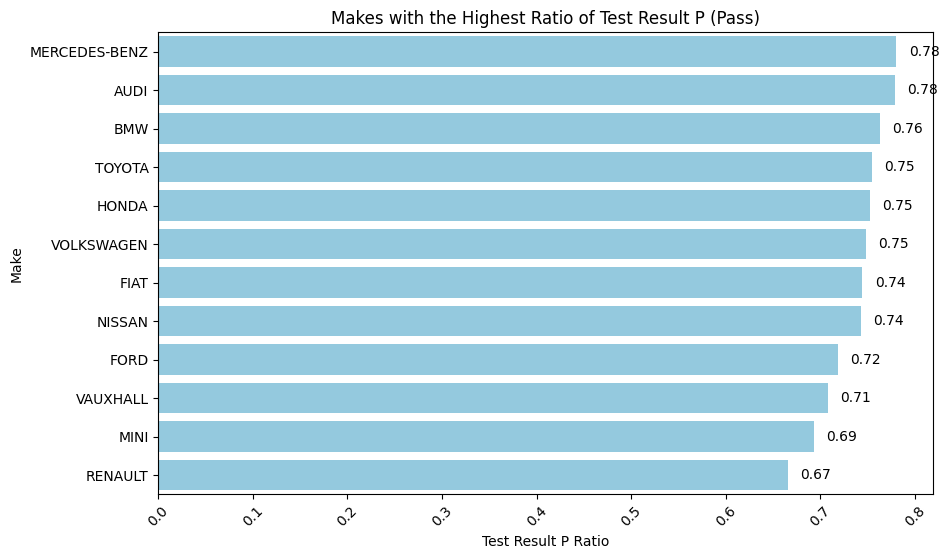

In [26]:

# Find the makes with the highest ratio of test_result = P
make_counts = mot['make'].value_counts()
make_p_counts = mot[mot['test_result'] == 'P']['make'].value_counts()
make_p_ratio = make_p_counts / make_counts
make_p_ratio = make_p_ratio.sort_values(ascending=False)

# Convert the Series to DataFrame for plotting
make_p_ratio_df = make_p_ratio.reset_index()
make_p_ratio_df.columns = ['Make', 'Test Result P Ratio']

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    y='Make',  # Now 'Make' is on the y-axis
    x='Test Result P Ratio',  # And 'Test Result P Ratio' on the x-axis
    data=make_p_ratio_df,
    color='skyblue'
)

# Adding a title and labels
plt.title('Makes with the Highest Ratio of Test Result P (Pass)')
plt.ylabel('Make')  # Now this is the y-axis label
plt.xlabel('Test Result P Ratio')  # And this is the x-axis label

plt.xticks(rotation=45)
plt.yticks(rotation=0)  # You can adjust the rotation for readability if needed

# Add value labels next to the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),  # Change to get_width() because width is the measure now
                     (p.get_width(), p.get_y() + p.get_height() / 2.),  # Adjust position to be at the end of the bar
                     ha='left', va='center',  # Align text to the left of the endpoint
                     xytext=(9, 0),  # Move text to the right a bit
                     textcoords='offset points')

barplot.set_facecolor('white')

# Show the plot
plt.show()



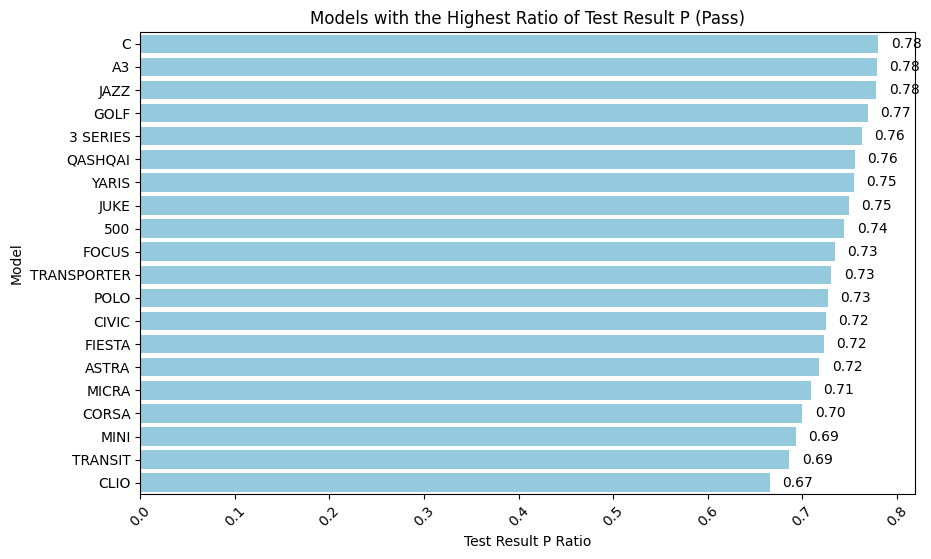

In [25]:

# Find the models with the highest ratio of test_result = P
model_counts = mot['model'].value_counts()
model_p_counts = mot[mot['test_result'] == 'P']['model'].value_counts()
model_p_ratio = model_p_counts / model_counts
model_p_ratio = model_p_ratio.sort_values(ascending=False)

# Convert the Series to DataFrame for plotting
model_p_ratio_df = model_p_ratio.reset_index()
model_p_ratio_df.columns = ['Model', 'Test Result P Ratio']

plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    y='Model',  # 'Model' is now on the y-axis
    x='Test Result P Ratio',  # 'Test Result P Ratio' is on the x-axis
    data=model_p_ratio_df,
    color='skyblue'
)

# Adding a title and labels
plt.title('Models with the Highest Ratio of Test Result P (Pass)')
plt.ylabel('Model')  # y-axis label is now 'Model'
plt.xlabel('Test Result P Ratio')  # x-axis label is 'Test Result P Ratio'

plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Add value labels next to the bars
for p in barplot.patches:
    barplot.annotate(format(p.get_width(), '.2f'),  # Using get_width() for horizontal bars
                     (p.get_width(), p.get_y() + p.get_height() / 2.),  # Position at the end of the bar
                     ha='left', va='center',  # Align text to the left of the endpoint
                     xytext=(9, 0),  # Move text to the right a bit
                     textcoords='offset points')

barplot.set_facecolor('white')

# Show the plot
plt.show()

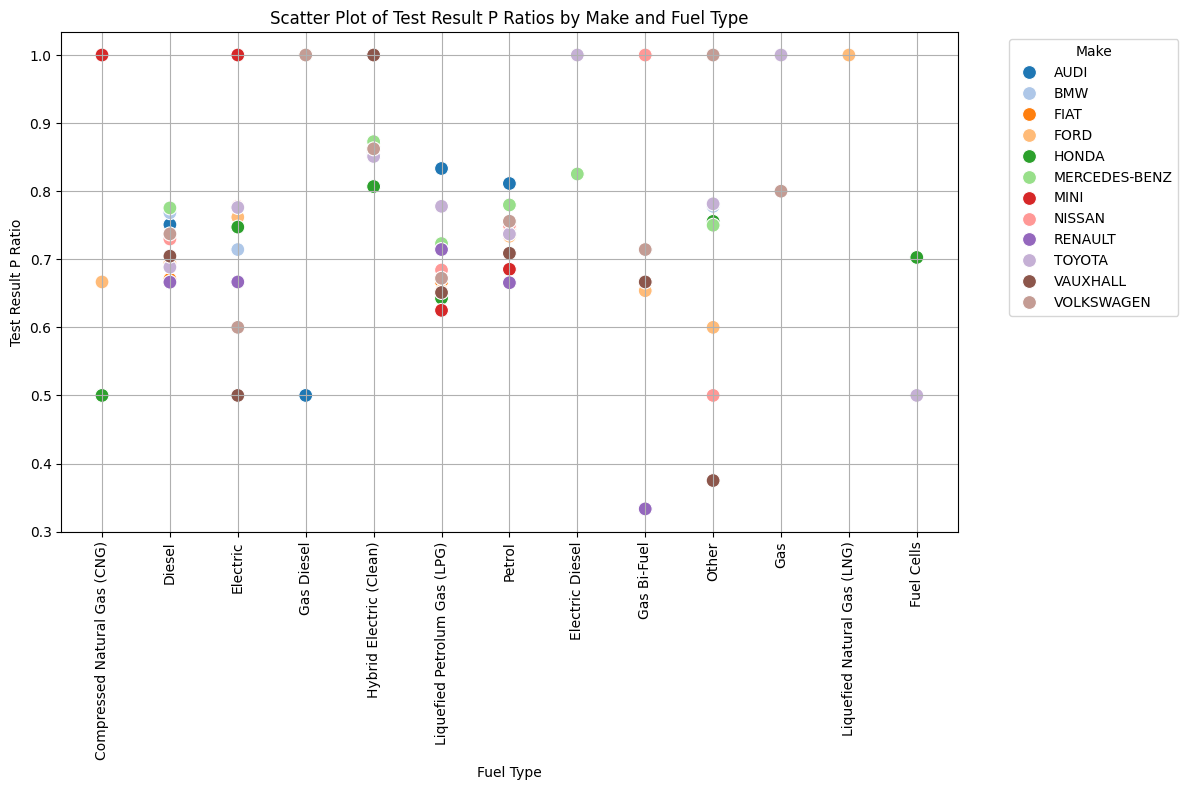

In [16]:

# Calculate counts and ratios as before, change to grouping by 'make'
make_fuel_counts = mot.groupby(['make', 'fuel_type_desc']).size()
make_p_fuel_counts = mot[mot['test_result'] == 'P'].groupby(['make', 'fuel_type_desc']).size()
make_p_ratio = make_p_fuel_counts / make_fuel_counts

# Resetting the index to turn the multi-index Series into a DataFrame
make_p_ratio_df = make_p_ratio.reset_index()
make_p_ratio_df.columns = ['Make', 'Fuel Type', 'Test Result P Ratio']

# Create a scatter plot
plt.figure(figsize=(12, 8))
scatter_plot = sns.scatterplot(
    x='Fuel Type',
    y='Test Result P Ratio',
    hue='Make',  # Differentiate by make
    data=make_p_ratio_df,
    palette='tab20',  # Color palette
    s=100  # Size of the markers
)

plt.title('Scatter Plot of Test Result P Ratios by Make and Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Test Result P Ratio')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(True)  # Add grid for easier visual alignment

# Moving the legend outside the plot area to the right
plt.legend(title='Make', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()  # Adjust the layout to make room for the legend
plt.show()

It would also be nice to understand the distribution of test results for each model. Let us try a visualisation which might help - we will facet a scatter plot for each model into a single grid.

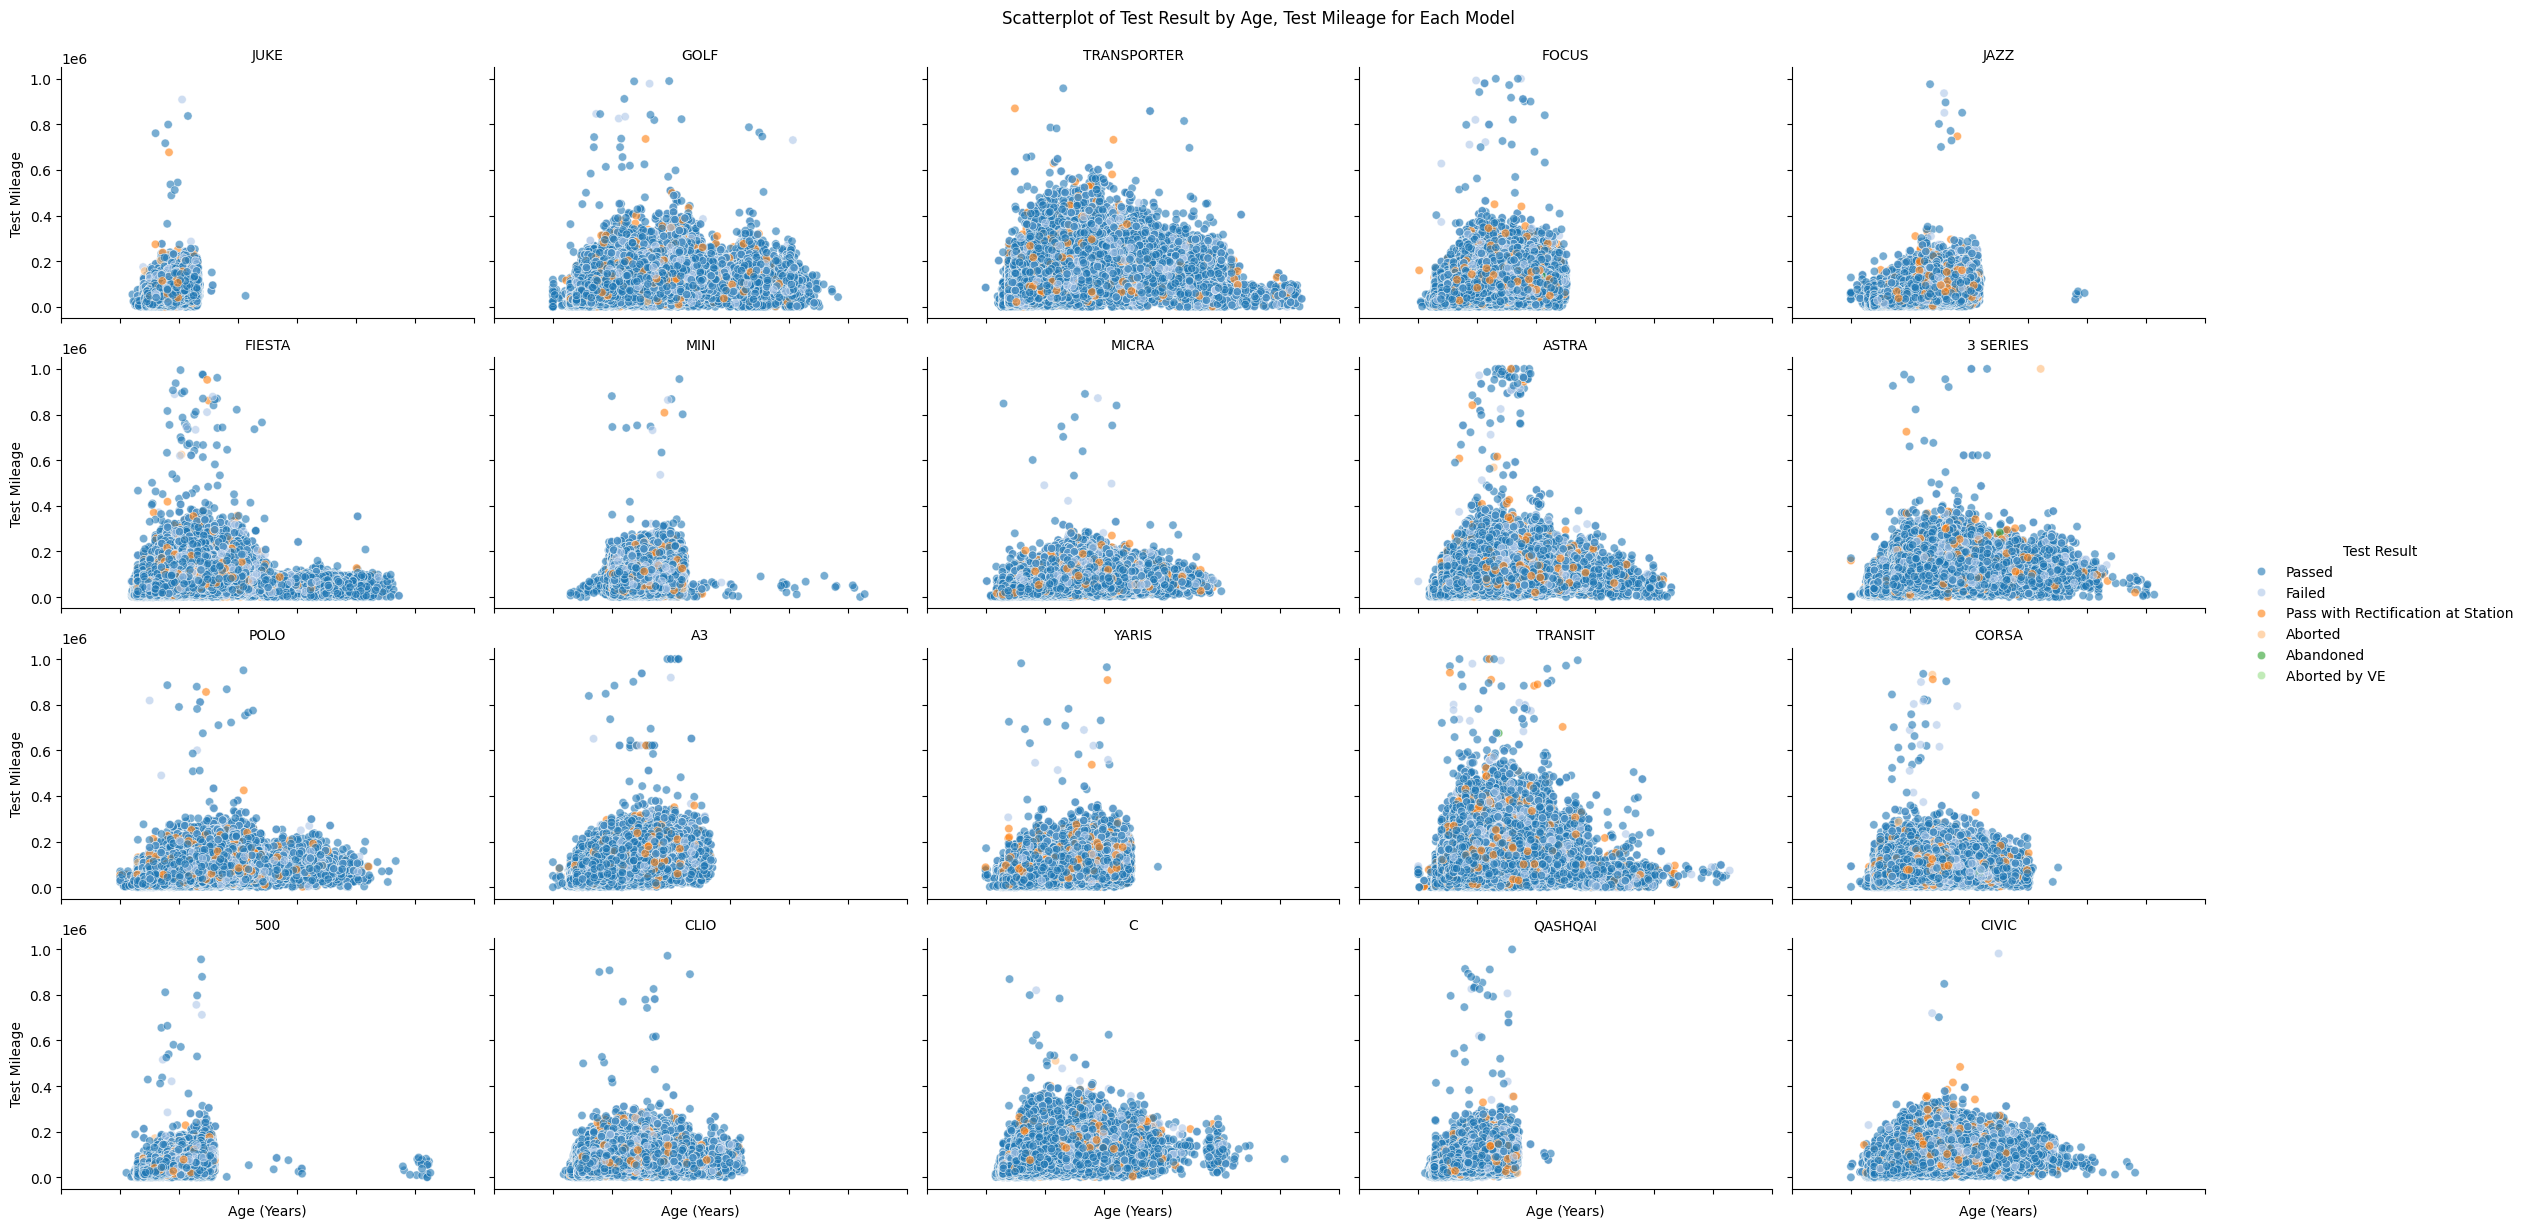

In [27]:
# Initialize a FacetGrid object
g = sns.FacetGrid(mot, col='model', col_wrap=5, aspect=1.5)

# Map the scatterplot with the Spectral colormap for the 'cylinder_capacity' which affects the color
g.map_dataframe(sns.scatterplot,
                'age_years',
                'test_mileage', 
                 alpha=0.6,
                 palette='tab20',
                 hue='test_result_desc',
                 hue_order=['Passed', 'Failed', 'Pass with Rectification at Station', 'Aborted', 'Abandoned', 'Aborted by VE']
                 )

# Add titles and tweak adjustments
g.set_titles("{col_name}")  # Use model names as titles for each subplot
g.set_axis_labels("Age (Years)", "Test Mileage")  # Set common axis labels
g.set_xticklabels(rotation=45)

# Add a legend and adjust layout
g.add_legend(title='Test Result')
g.tight_layout()

# Set the overall title
plt.suptitle('Scatterplot of Test Result by Age, Test Mileage for Each Model', y=1.02)

# Display the plots
plt.show()

This makes for an interesting visualisation, even if somewhat complex to interpret visually. However it helps us understand the distribution of test results for each model, and helps paint a narrative of the data. You can think of your own ideas on how to improve this, or take whole different approaches.

```{tip}
A great book I highly recomment is ["The Visual Display of Quantitative Information"](https://www.edwardtufte.com/tufte/books_vdqi?gad_source=1&gclid=Cj0KCQjwir2xBhC_ARIsAMTXk86rOtorEShrFpEEtS1Uie2aHGztvlDaQ-Qxl3coQhEr-B8X3IZQsWsaAntIEALw_wcB) by Edward Tufte. It is a great resource for learning how to visualise data in a way that is both informative and visually appealing.
```

## Developing a classification model

Let us now develop a classification model to predict the likely test result of a car based on its features. You might have noticed above that there is a wide disparity in the number of tests for different makes and models, as well as the test results. To ensure we have a true representation of the original distribution, we will perform stratified sampling to ensure we have a balanced dataset.

```{tip}
Stratified sampling is a statistical method used to ensure that specific subgroups within a dataset are adequately represented when taking a sample. This approach involves dividing the entire population into different subgroups known as strata, which are based on shared characteristics. Once the population is divided, a sample is drawn from each stratum. 

The main reason for using stratified sampling is to capture the population heterogeneity in the sample. For example, if you were conducting a survey on a population consisting of both males and females and you know that their responses might vary significantly based on gender, stratified sampling allows you to ensure that both genders are properly represented in the sample according to their proportion in the full population. This method enhances the accuracy of the results since each subgroup is proportionally represented, and it also increases the overall efficiency of the sampling process because it can require fewer resources to achieve more precise results.

Stratified sampling is especially valuable when analysts need to ensure that smaller but important subgroups within the population are not overlooked. By ensuring that these subgroups are adequately sampled, researchers can draw more accurate and generalizable conclusions from their data analysis. This makes stratified sampling a preferred method in fields where precision in population representation is crucial, such as in medical research, market research, and social science studies.
```

We will sample on the `test_result_desc` column, as this is the target variable we are trying to predict.

In [18]:
from sklearn.model_selection import train_test_split

def stratified_sample(data, column, fraction):
    # Use train_test_split to perform the stratified sampling
    _, sampled = train_test_split(
        data, 
        test_size=fraction, 
        stratify=data[column],  # Stratify by the column to keep the distribution
        random_state=42  # For reproducibility
    )

    # Drop any categories with less than 100 samples
    sampled = sampled.groupby(column).filter(lambda x: len(x) > 100)
    
    return sampled

# Use only a fraction of the data for faster processing and less memory usage
mot_encoded = stratified_sample(mot, 'test_result_desc', 0.2)

# Show the distribution of the test_result column
print(mot_encoded['test_result'].value_counts())
print(mot_encoded.shape)

test_result
P      1936124
F       554208
PRS     138291
ABR      14102
ABA       1873
Name: count, dtype: int64
(2644598, 18)


Now we will do a number of things:

1. Since we have a number of categorical variables, and will be evaluating an `LightGBM` classification model, we will need to encode these variables.
2. We will split the data into training and testing sets, but based on a fraction of the original set (to fit on the memory constraints of my environment).
3. We will also be evaluating a `RandomForest` classifier, and to ensure a balanced dataset, we will use class weights in the model parameters - in this case, we will use the `balanced` and `balanced_subsample` class weight strategies.
4. We will finally train the models and evaluate their performance, using `GridSearchCV` to find the best hyperparameters.

```{tip}
LightGBM (Light Gradient Boosting Machine) is an efficient and scalable implementation of gradient boosting framework by Microsoft. It is designed to be distributed and efficient with the following advantages: faster training speed and higher efficiency, lower memory usage, better accuracy, support of parallel and GPU learning, and capable of handling large-scale data.

The core algorithm of LightGBM is based on decision tree algorithms and it uses gradient boosting framework. Trees are built leaf-wise as opposed to level-wise as commonly seen in other boosting frameworks like XGBoost. This means that LightGBM will choose the leaf with max delta loss to grow during tree growth. It can reduce more loss than a level-wise algorithm, which is one of the main reasons for its efficiency.

Core Concepts and Techniques

**Gradient Boosting**: Like other boosting methods, LightGBM converts weak learners into a strong learner in an iterative fashion. It constructs new trees that model the errors or residuals of the prior trees added together as a new prediction.

**Histogram-based Algorithms**: LightGBM uses histogram-based algorithms for speed and memory efficiency. It buckets continuous feature (attribute) values into discrete bins which speeds up the training process and reduces memory usage significantly.

**Leaf-wise Tree Growth**: Unlike other boosting frameworks that grow trees level-wise, LightGBM grows trees leaf-wise. It chooses the leaf that minimizes the loss, allowing for lower-loss models and thus leading to better accuracy.

Mathematically, the objective function that LightGBM minimizes can be described as follows:

$$
L(\Theta) = \sum_{i=1}^N l(y_i, \hat{y}_i) + \sum_{k=1}^K \Omega(f_k)
$$

where $\mathbf{N}$ is the number of data points, $\mathbf{y_i}$ is the actual label, $\hat{y}_i$ is the predicted label, $\mathbf{l}$ is the loss function, $\mathbf{K}$ is the number of trees, $\mathbf{f_k}$ is the model from tree $\mathbf{k}$, and $\mathbf{\Omega}$ is the regularization term.

**Loss Function**: The loss function $l(y, \hat{y})$ depends on the specific task (e.g., mean squared error for regression, logistic loss for binary classification).

**Regularization**: LightGBM also includes regularization terms $\Omega(f)$, which help to prevent overfitting. These terms can include L1 and L2 regularization on the weights of the leaves.

**Exclusive Feature Bundling (EFB)**: This is an optimization to reduce the number of features in a dataset with many sparse features. EFB bundles mutually exclusive features (i.e., features that rarely take non-zero values simultaneously) into a single feature, thus reducing the feature dimension without hurting model accuracy.

**GOSS (Gradient-based One-Side Sampling)** and **DART (Dropouts meet Multiple Additive Regression Trees)** are other techniques LightGBM uses to manage data samples and boost performance effectively.

LightGBM is highly customizable with a lot of hyper-parameters such as `num_leaves`, `min_data_in_leaf`, and `max_depth`, which control the complexity of the model. Hyper-parameter tuning plays a crucial role in harnessing the full potential of LightGBM.
```

In [19]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import time

# Encode the categorical columns
le = LabelEncoder()
categorical_columns = ['make', 'model', 'fuel_type', 'postcode_area', 'test_result_desc']
for col in categorical_columns:
    mot_encoded[col] = le.fit_transform(mot_encoded[col])

X = mot_encoded[['test_mileage', 'cylinder_capacity', 'age_years', 'make', 'model', 'fuel_type', 'postcode_area']]
y = mot_encoded['test_result_desc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setting up parameter grids for each model
param_grid = {
    'RandomForest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [5, 10, 20, None],
            'class_weight': [None, 'balanced']
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(random_state=42),
        'params': {
            'n_estimators': [50, 100],
            'num_leaves': [31, 62],  # Default is 31
            'learning_rate': [0.1, 0.01],
            'class_weight': [None, 'balanced']
        }
    },
}

# Store results
results = []

# Run GridSearchCV for each model
for model_name, mp in param_grid.items():
    print(f'Running GridSearchCV for {model_name}')
    start_time = time.time()
    skf = StratifiedKFold(n_splits=2)  # Adjusted to 2 to match the smallest class size
    clf = GridSearchCV(mp['model'], mp['params'], cv=skf, scoring='accuracy', verbose=0, n_jobs=-1)
    clf.fit(X_train, y_train)
    end_time = time.time()
    print(f'Finished in {end_time - start_time:.2f} seconds')
    results.append({
        'model_name': model_name,
        'model': clf.best_estimator_,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'train_duration': end_time - start_time
    })

# Display results
for result in results:
    print(f"Model: {result['model_name']}")
    print(f"\tBest Score: {result['best_score']}")
    print(f"\tBest Parameters: {result['best_params']}")
    print(f"\tTraining Duration: {result['train_duration']} seconds")


Running GridSearchCV for RandomForest


/Users/NLeitao/.pyenv/versions/3.9.18/envs/ml-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished in 686.75 seconds
Running GridSearchCV for LightGBM
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012373 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014329 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 1057839, number of used features: 7
[LightGBM] [Info] Number of data points in the train set: 1057839, number of used features: 7
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009161 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightG

/Users/NLeitao/.pyenv/versions/3.9.18/envs/ml-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.148966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 856
[LightGBM] [Info] Number of data points in the train set: 1057839, number of used features: 7
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.170753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 1057839, number of used features: 7
[LightGBM] [Info] Start training from score -1.609438
[LightGBM] [Info] Start training f

Now that we know the best model and set of hyperparameters, we can train the model on a larger portion of the dataset and evaluate its performance.

In [20]:
# Find the best model from the results
best_model = max(results, key=lambda x: x['best_score'])

mot_encoded = stratified_sample(mot, 'test_result_desc', 0.75)

# Encode the categorical columns
le = LabelEncoder()
for col in categorical_columns:
    mot_encoded[col] = le.fit_transform(mot_encoded[col])

X = mot_encoded[['test_mileage', 'cylinder_capacity', 'age_years', 'make', 'model', 'fuel_type', 'postcode_area']]
y = mot_encoded['test_result_desc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model['model'].fit(X_train, y_train)
y_pred = best_model['model'].predict(X_test)


And now let us print the classification report for the model, as well as the confusion matrix.

                                    precision    recall  f1-score   support

                         Abandoned       1.00      0.00      0.00      1346
                           Aborted       0.68      0.83      0.75     10504
                            Failed       1.00      0.00      0.00    414314
Pass with Rectification at Station       1.00      0.00      0.00    104184
                            Passed       0.74      1.00      0.85   1453100

                          accuracy                           0.74   1983448
                         macro avg       0.88      0.37      0.32   1983448
                      weighted avg       0.81      0.74      0.63   1983448

Accuracy: 0.7361231552327059


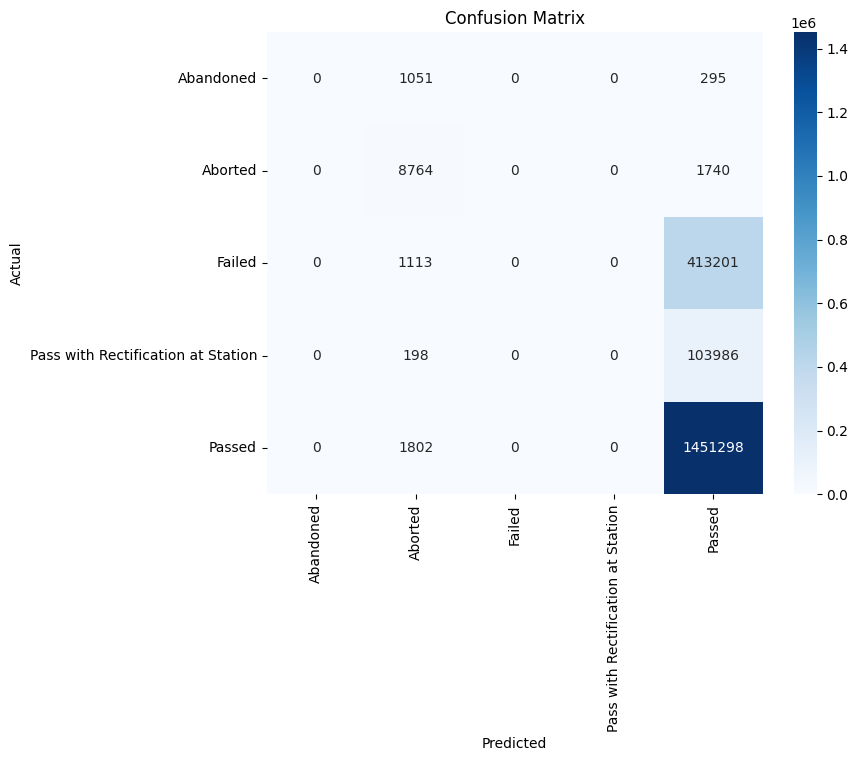

In [21]:
from sklearn.metrics import confusion_matrix

# Display the classification report and accuracy score, decode the labels
print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=1))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Analysis of training results

**Abandoned**: Although the precision is perfect (1.00), the recall is 0%, which results in an F1-score of 0.00. This means that while every prediction of 'Abandoned' by the classifier is correct, the classifier almost never predicts 'Abandoned' (possibly only predicting it correctly once or a few times, or none at all).

**Aborted**: Has reasonable precision (0.68) and good recall (0.83), leading to a relatively high F1-score of 0.75. This indicates a balanced performance for this class with a higher likelihood of predicting 'Aborted' correctly.

**Failed**: Similar to 'Abandoned', has a precision of 1.00 but a recall of 0.00, resulting in an F1-score of 0.00. This suggests the classifier is extremely conservative or inaccurate in predicting this class, potentially only making a correct prediction a very few times or none.

**Pass with Rectification at Station**: Also shows a pattern of high precision (1.00) but extremely low recall (0.00), with an F1-score of 0.00, indicating poor predictive performance for this category.
Passed: Shows high precision (0.74) and perfect recall (1.00), with an F1-score of 0.85. This suggests the classifier is highly effective at identifying and predicting 'Passed' correctly, likely predicting most instances of this class.

**Accuracy**: Overall, the classifier has an accuracy of 74%, which means it correctly predicts the label 74% of the time across all predictions.

**Macro Average**: The macro-average F1-score (0.32) is low, which indicates significant variability in effectiveness across classes, with some classes being predicted very well and others very poorly.

**Weighted Average**: The weighted average F1-score (0.63) is higher than the macro avg, reflecting that the classifier's performance is better on the classes with more samples ('Passed').

The classifier performs very well on large classes like 'Passed' but struggles with smaller or more difficult classes like 'Abandoned', 'Failed', and 'Pass with Rectification at Station', showing a potential issue with class imbalance or features not being indicative for some classes. Adjusting the class weight, improving feature engineering, or trying different models might help improve performance across these underperforming classes.

## Final remarks

In this experiment, we have analysed the MOT test results of cars in the UK, focusing on the top most tested cars in the dataset. We have performed some exploratory analysis to understand the distribution of test results, vehicle age, and mileage, and have developed a classification model to predict the likely test result of a car based on its features.

We have used a stratified sampling approach to ensure a balanced dataset, and have evaluated the performance of two classification models - LightGBM and RandomForest. We have found that the LightGBM model performs better than the RandomForest model, with an accuracy of 74% and a weighted average F1-score of 0.63. However we have also identified some classes that the model struggles with, and this would be a great exercise to improve the model further.
